In [20]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt

In [21]:
# Import data
data = pd.read_csv("data.csv",sep=";")
data['date'] = pd.to_datetime(data['date'])  # First, ensure that "date" is in datetime format
data.head()

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,w_m,N
0,10001,2009-12-31,0.162621,4361.0,10.3000,44918.3000,43871.6600,0.000032,0.028475,1,0.162589,0.028443,0.000005,91
1,10001,2010-01-29,-0.018932,4361.0,10.0600,43871.6600,43646.6324,0.000013,-0.037172,1,-0.018945,-0.037185,0.000005,91
2,10001,2010-02-26,-0.000656,4361.0,10.0084,43646.6324,44351.3700,0.000061,0.034744,1,-0.000717,0.034683,0.000004,91
3,10001,2010-03-31,0.020643,4361.0,10.1700,44351.3700,69137.3000,0.000112,0.063668,1,0.020531,0.063556,0.000007,91
4,10001,2010-04-30,0.124385,6070.0,11.3900,69137.3000,69209.4000,0.000118,0.020036,1,0.124267,0.019918,0.000007,91


In [22]:
window = 60
min_periods = 36

data['beta_iv'] = data.groupby('permno').apply(
    lambda x: x['Rn_e'].rolling(window, min_periods=min_periods).cov(x['Rm_e']) /
              x['Rm_e'].rolling(window, min_periods=min_periods).var()
).reset_index(level=0, drop=True)

data['sigma_idio'] = np.sqrt(
    data.groupby('permno').apply(
        lambda x: (x['Rn_e'] - x['beta_iv']*x['Rm_e']).rolling(window, min_periods=min_periods).var()
    ).reset_index(level=0, drop=True)
)


/var/folders/s3/w3_938yj6mb4c7_8trrtc56h0000gn/T/ipykernel_5634/3420196756.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data['beta_iv'] = data.groupby('permno').apply(
/var/folders/s3/w3_938yj6mb4c7_8trrtc56h0000gn/T/ipykernel_5634/3420196756.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data.groupby('permno').apply(


In [23]:
# Winsorize 5%-95%
data['sigma_idio'] = data['sigma_idio'].clip(
    data['sigma_idio'].quantile(0.05),
    data['sigma_idio'].quantile(0.95)
)

# Déciles
q = 10
data = data.dropna(subset=['sigma_idio']).copy()
data['IV_Q'] = data.groupby('date')['sigma_idio'].transform(
    lambda x: pd.qcut(x, q, labels=False, duplicates='drop')
)

# Value-weighted
data['vw_IV'] = data['mcap']/data.groupby(['date','IV_Q'])['mcap'].transform('sum')
data['IV_ret_vw'] = data['vw_IV'] * data['Rn']


In [24]:
# Long top 3 déciles, short bottom 3 déciles
data['w_L_vw'] = data['vw_IV'] * data['IV_Q'].isin([7,8,9])
data['w_S_vw'] = data['vw_IV'] * data['IV_Q'].isin([0,1,2])

# Normalisation des poids par date
data['w_L_vw'] /= data.groupby('date')['w_L_vw'].transform('sum')
data['w_S_vw'] /= data.groupby('date')['w_S_vw'].transform('sum')

# Poids long-short
data['w_IV'] = data['w_L_vw'] - data['w_S_vw']

# Factor returns
IV_factor = data.groupby('date').apply(lambda x: np.sum(x['Rn']*x['w_IV'])).reset_index(name='IV_ret')
IV_factor['date'] = IV_factor['date'] + pd.DateOffset(months=1)


/var/folders/s3/w3_938yj6mb4c7_8trrtc56h0000gn/T/ipykernel_5634/1103589867.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  IV_factor = data.groupby('date').apply(lambda x: np.sum(x['Rn']*x['w_IV'])).reset_index(name='IV_ret')


In [25]:
from scipy.stats import ttest_1samp

def stats_portfolio(ret_series, label='IV Factor'):
    mean_ann = ret_series.mean()*12
    std_ann = ret_series.std()*np.sqrt(12)
    sharpe_ann = mean_ann/std_ann
    t_stat, p_value = ttest_1samp(ret_series, 0)
    print(f"{label} Return Annualized: {mean_ann:.4f}")
    print(f"{label} Std Annualized: {std_ann:.4f}")
    print(f"{label} Sharpe: {sharpe_ann:.4f}")
    print(f"{label} t-stat: {t_stat:.4f}, p-value: {p_value:.4f}\n")
    return mean_ann, std_ann, sharpe_ann

stats_portfolio(IV_factor['IV_ret'], 'IV Factor VW')


IV Factor VW Return Annualized: 0.2560
IV Factor VW Std Annualized: 0.3124
IV Factor VW Sharpe: 0.8196
IV Factor VW t-stat: 6.0271, p-value: 0.0000



(0.2560495502638166, 0.3124247327679099, 0.8195559551107224)

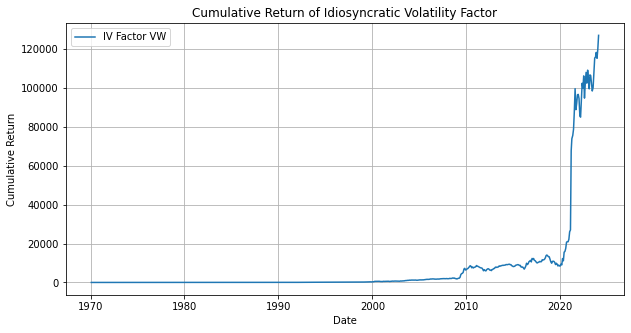

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot((IV_factor.set_index('date')['IV_ret'] + 1).cumprod(), label='IV Factor VW')
plt.title('Cumulative Return of Idiosyncratic Volatility Factor')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.show()


In [27]:
IV_factor_vw = IV_factor[['date','IV_ret']].copy()
IV_factor_vw.to_csv('IV_factor_VW.csv', index=False)